### 필요 라이브러리 설치

In [0]:
# To ignore deprecated warnings
import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)

import torch # torch library 
import torch.nn as nn # Nueral Network에 대한 package
import numpy as np  # numpy 
import editdistance # 평가 지표로서 사용될 edit distance 
import matplotlib.pyplot as plt # plot 을 찍기 위한 라이브러리
import tqdm
import torch.nn.functional as F # pytorch function 들을 사용하기 위한 용도 
from torch.utils import data # dataset 관련된 utility 를 사용하려는 용도
from random import choice, randrange # random
from itertools import zip_longest 
import librosa
import os   # directory 생성 및 디렉토리 생성과 관련된 package 
import json 
import random
import subprocess
import pickle

In [0]:
def batch(iterable, n=1):
    args = [iter(iterable)] * n
    return zip_longest(*args)


def pad_tensor(vec, pad, value=0, dim=0):
    """
    pad token으로 채우는 용도 
    args:
        vec - tensor to pad
        pad - the size to pad to
        dim - dimension to pad
    return:
        a new tensor padded to 'pad' in dimension 'dim'
    """
    pad_size = pad - vec.shape[0]

    if len(vec.shape) == 2:
        zeros = torch.ones((pad_size, vec.shape[-1])) * value
    elif len(vec.shape) == 1:
        zeros = torch.ones((pad_size,)) * value
    else:
        raise NotImplementedError
    return torch.cat([torch.Tensor(vec), zeros], dim=dim)


In [0]:
def pad_collate(batch, values=(0, 0), dim=0):
    """
    데이터 로더에 들어가기전에 batch화 할 때 거치는 함수 
    args:
        batch - list of (tensor, label)
    reutrn:
        xs - a tensor of all examples in 'batch' after padding
        ys - a LongTensor of all labels in batch
        ws - a tensor of sequence lengths
    """

    sequence_lengths = torch.Tensor([int(x[0].shape[dim]) for x in batch]) # 각 batch 마다 길이를 얻어내고 
    sequence_lengths, xids = sequence_lengths.sort(descending=True) # 감소하는 순서로 정렬
    target_lengths = torch.Tensor([int(x[1].shape[dim]) for x in batch])
    # find longest sequence (가장 긴 sequence의 길이를 구함 )
    src_max_len = max(map(lambda x: x[0].shape[dim], batch))
    tgt_max_len = max(map(lambda x: x[1].shape[dim], batch))
    # pad according to max_len (max length 만큼 padd를 추가 )
    batch = [(pad_tensor(x, pad=src_max_len, dim=dim), pad_tensor(y, pad=tgt_max_len, dim=dim)) for (x, y) in batch]

    # stack all
    xs = torch.stack([x[0] for x in batch], dim=0)
    ys = torch.stack([x[1] for x in batch], dim=0)
    xs = xs[xids].contiguous() # decreasing order로 다시 나열 
    ys = ys[xids].contiguous() # xids 와 같은 순서로 
    target_lengths = target_lengths[xids] 
    return xs.long(), ys.long(), sequence_lengths.int(), target_lengths.int()


class ToyDataset(data.Dataset):
    """
    https://talbaumel.github.io/blog/attention/
    """
    def __init__(self, min_length=5, max_length=20, type='train'):
        self.SOS = "<s>"  # all strings will end with the End Of String token )
        self.EOS = "</s>"  # all strings will end with the End Of String token
        self.characters = list("abcdefg")
        self.int2char = list(self.characters)
        self.char2int = {c: i+3 for i, c in enumerate(self.characters)} # +3 을 왜하는 가?
        print(self.char2int)
        self.VOCAB_SIZE = len(self.characters)
        self.min_length = min_length
        self.max_length = max_length
        
        # train set or test set 을 생성 
        if type == 'train':
            self.set = [self._sample() for _ in range(4000)]
        else:
            self.set = [self._sample() for _ in range(300)]

    def __len__(self):
        return len(self.set)

    def __getitem__(self, item):
        return self.set[item]

    def _sample(self):
        random_length = randrange(self.min_length, self.max_length)  # Pick a random length
        random_char_list = [choice(self.characters[:-1]) for _ in range(random_length)]  # Pick random chars
        random_string = ''.join(random_char_list)
        a = np.array([self.char2int.get(x) for x in random_string]+[2])
        b = np.array([self.char2int.get(x) for x in random_string[::-1]] + [2]) # Return the random string and its reverse + EOS 
        
        return a, b

### Attention Mask

In [0]:
## 추후에 설명 Decoder section
def mask_3d(inputs, seq_len, mask_value=0.):
    batches = inputs.size()[0]
    assert batches == len(seq_len) # length 체크 
    max_idx = max(seq_len) # max length 체크 
    for n, idx in enumerate(seq_len): # length 에서 의미없는 hidden state attention 값은 0으로 두기 위한 mask값 설정 
        if idx < max_idx.item():
            if len(inputs.size()) == 3:
                inputs[n, idx.int():, :] = mask_value
            else:
                assert len(inputs.size()) == 2, "The size of inputs must be 2 or 3, received {}".format(inputs.size())
                inputs[n, idx.int():] = mask_value
    return inputs

#### ENCODER RNN Code

In [0]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class EncoderRNN(nn.Module):
    def __init__(self, config):
        super(EncoderRNN, self).__init__()
        self.input_size = config["n_channels"]
        self.hidden_size = config["encoder_hidden"]
        self.layers = config.get("encoder_layers", 1)
        
        self.dropout = config.get("encoder_dropout", 0.) 
        self.bi = config.get("bidirectional_encoder", False)
        embedding_dim = config.get("embedding_dim", None)
        self.embedding_dim = embedding_dim if embedding_dim is not None else self.hidden_size
        self.Embedding = nn.Embedding(config.get("vocab_size", 32), self.embedding_dim, padding_idx=0)
        gru_input_dim = self.embedding_dim
        self.GRU = nn.GRU(
            gru_input_dim,
            self.hidden_size,
            self.layers,
            dropout=self.dropout,
            bidirectional=self.bi,
            batch_first=True)# model 선언 
        self.gpu = config.get("gpu", False) 



    def forward(self, inputs, hidden, input_lengths):
        ## (To do) 이 부분의 코드를 완성하시오! 
        #제공된 코드를 수정하지 않고 forward 문만 작성하여 코드를 구현해 주세요!
        #기존 코드를 수정하지 않고 코드를 구현해 주세요!

    def init_hidden(self, batch_size,config):
        ## (To do) 이 부분의 코드를 완성하시오!
        #제공된 코드의 다른 부분을 수정하지 않고 init_hidden 코드를 구현해 주세요!
        #기존 코드를 수정하지 않고 코드를 구현해 주세요!
        

### Decoder 

In [0]:
class Decoder(nn.Module):
    def __init__(self, config):
        super(Decoder, self).__init__()
        self.batch_size = config["batch_size"]
        self.hidden_size = config["decoder_hidden"]
        embedding_dim = config.get("embedding_dim", None)
        self.embedding_dim = embedding_dim if embedding_dim is not None else self.hidden_size
        self.Embedding = nn.Embedding(config.get("vocab_size", 32), self.embedding_dim, padding_idx=0)
        self.GRU = nn.GRU(
            input_size=self.embedding_dim+self.hidden_size if config['decoder'].lower() == 'bahdanau' else self.embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=config.get("decoder_layers", 1),
            dropout=config.get("decoder_dropout", 0),
            bidirectional=False,
            batch_first=True)
        if config['decoder'] != "RNN":
            self.Attention = Attention(
                self.batch_size,
                self.hidden_size,
                method=config.get("attention_score", "dot"))

        self.gpu = config.get("gpu", False)
        self.decoder_output_fn = F.log_softmax if config.get('loss', 'NLL') == 'NLL' else None

    def forward(self, **kwargs):
        """ Must be overrided """
        raise NotImplementedError

In [0]:
class Attention(nn.Module):
    """
    Inputs:
        last_hidden: (batch_size, hidden_size)
        encoder_outputs: (batch_size, max_time, hidden_size)
    Returns:
        attention_weights: (batch_size, max_time)
    """
    def __init__(self, batch_size, hidden_size, method="dot"):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        if method == 'dot':
            pass
        elif method == 'general':
            # Wa (hidden,hidden)
            self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
        elif method == "concat":
            # Wa : (2*hidden,hidden)
            # Va : (hidden,1)
            self.Wa = nn.Linear(2*hidden_size, hidden_size, bias=False)
            self.va = nn.Parameter(torch.FloatTensor(hidden_size, 1))
        elif method == 'bahdanau':
            # Wa : (hidden_size,hidden_size) 
            # Ua : (hidden_size,hidden_size)
            # Va : (hidden_size,1)
            self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
            self.Ua = nn.Linear(hidden_size, hidden_size, bias=False)
            self.va = nn.Parameter(torch.FloatTensor(hidden_size, 1))
        else:
            raise NotImplementedError

        
    def forward(self, last_hidden, encoder_outputs, seq_len=None):
        """
        Inputs :
          last_hidden : (B,T,hidden_size)
          encoder_outputs : 
          seq_len:  
        Returns:
          attention matrix : 
        """
        batch_size, seq_lens, _ = encoder_outputs.size()
        # attention energies 를 구하기 
        attention_energies = self.score(last_hidden, encoder_outputs, self.method)
        
        if seq_len is not None:
            attention_energies = mask_3d(attention_energies, seq_len, -float('inf'))

        return F.softmax(attention_energies, -1)

    def score(self, last_hidden, encoder_outputs, method):
        # (To do) 코드를 완성하시오 
        #기존 코드를 수정하지 않고 코드를 구현해 주세요!
      

In [0]:
class Seq2Seq(nn.Module):
    """
        Sequence to sequence module
    """

    def __init__(self, config):
        super(Seq2Seq, self).__init__()
        self.config = config
        self.SOS = config.get("start_index", 1) # Start index를 가져옵니다. 
        self.vocab_size = config.get("vocab_size", 32) # embedding 에 필요한 vocabulary size 
        self.batch_size = config.get("batch_size", 1) # batch_size 정보를 가져옵니다.
        self.gpu = config.get("gpu", False) # cuda 로 돌아가는지 아닌지에 대한 정보 

        # Encoder 선언
        
        self.encoder = EncoderRNN(config)

        # Decoder 선언 
        
        self.decoder = LoungDecoder(config)
        
        # loss fucntion 
        # ignore_index =0 왜???
        self.loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0)
        
        

    def encode(self, x, x_len):
        # encoder를 통해 주어진 source 정보를 Encodeing 하는 용도 
        
        batch_size = x.size()[0]
        # 초기 inital hidden state 만들기
        init_state = self.encoder.init_hidden(batch_size,self.config)
        # encoder Forward 수행 
        encoder_outputs, encoder_state = self.encoder.forward(x, init_state, x_len)
        
        
       
        return encoder_outputs, encoder_state

    def decode(self, encoder_outputs, encoder_hidden, targets, targets_lengths, input_lengths):
        """
        Args:
            encoder_outputs: (B, T, H)
            encoder_hidden: (B, H)
            targets: (B, L)
            targets_lengths: (B)
            input_lengths: (B)
        Vars:
            decoder_input: (B)
            decoder_context: (B, H)
            hidden_state: (B, H)
            attention_weights: (B, T)
        Outputs:
            alignments: (L, T, B)
            logits: (B*L, V)
            labels: (B*L)
        """

        batch_size = encoder_outputs.size()[0]
        max_length = targets.size()[1]
        # decoder의 처음 y0 는 무엇이 되어야 할까? *주의해야할 포인트 
        if batch_size ==1:
          decoder_input = torch.LongTensor([self.SOS] * batch_size)
        else:
          decoder_input = torch.LongTensor([self.SOS] * batch_size).squeeze(-1)
        decoder_context = encoder_outputs.transpose(1, 0)[-1] #(Batch,1)
        decoder_hidden = encoder_hidden
        #alignments :  attention align을 저장하기 위한 용도  
        alignments = torch.zeros(max_length, encoder_outputs.size(1), batch_size) # attention align을 저장하기 위한 용도 
        logits = torch.zeros(max_length, batch_size, self.decoder.output_size) # logits 값을 저장하기 위한 용도의 tensor 

        if self.gpu:
            decoder_input = decoder_input.cuda()
            decoder_context = decoder_context.cuda()
            logits = logits.cuda()
        inference = []
        for t in range(max_length):

            # The decoder accepts, at each time step t :
            # - an input, [B]
            # - a context, [B, H]
            # - an hidden state, [B, H]
            # - encoder outputs, [B, T, H]
            
            # The decoder outputs, at each time step t :
            # - an output, [B]
            # - a context, [B, H]
            # - an hidden state, [B, H]
            # - weights, [B, T]

            outputs, decoder_hidden, attention_weights = self.decoder.forward(
                    input=decoder_input.long(),
                    last_hidden=decoder_hidden,
                    Encoder_Outputs=encoder_outputs,
                    Seq_Len=input_lengths)
            
            alignments[t] = attention_weights.transpose(1, 0)
            
            
            logits[t] = outputs

            

            if  self.training:
                decoder_input = targets[:, t]
            else:
                topv, topi = outputs.data.topk(1) # 가장 높은 예측만 사용.
                decoder_input = topi.squeeze(-1).detach()
                inference.append(decoder_input.cpu())

        
        labels = targets.contiguous().view(-1)

        
        mask_value = 0
        #what is this mask_3d? # (warning check)
        logits = mask_3d(logits.transpose(1, 0), targets_lengths, mask_value)
        logits = logits.contiguous().view(-1, self.vocab_size) # loss를 구하기 위해 쫙 펴주기 

        return logits, labels.long(), alignments,inference

    
    def step(self, batch):
        x, y, x_len, y_len = batch
        if self.gpu:
            x = x.cuda()
            y = y.cuda()
            x_len = x_len.cuda()
            y_len = y_len.cuda()

        encoder_out, encoder_state = self.encode(x, x_len) # encoder 
        logits, labels, alignments,inference = self.decode(encoder_out, encoder_state, y, y_len, x_len) # decoder 를 통해 alignment와 logit 값 얻기 
        return logits, labels, alignments,inference

    def loss(self, batch):
        logits, labels, alignments,inference = self.step(batch)
        loss = self.loss_fn(logits, labels) # loss 구하기 우리는 cross entropy 사용 
        return loss, logits, labels, alignments,inference

In [0]:
class LoungDecoder(Decoder):
    """
        Corresponds to LoungAttnDecoderRNN 
    """

    def __init__(self, config):
        super(LoungDecoder, self).__init__(config)
        self.output_size = config.get("vocab_size", 32)
        self.outputs2vocab = nn.Linear(self.hidden_size*2, self.output_size)
        
    def forward(self, **kwargs):

        #기존 코드를 수정하지 않고 코드를 구현해 주세요!


In [0]:
def train(model, optimizer, train_loader, epoch,n_epochs):
    

    losses = []
    cers = []

    
    model.train() # train mode 
    count = 0
    n_iter = 0
    for batch in train_loader:
        loss, _, _, _,_ = model.loss(batch)
        losses.append(loss.item())
        # Reset gradients
        optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        optimizer.step()
        n_iter+=1 # count number of iteration
        if n_iter % 10 == 0: # print loss only if it's training stage
            print ('\n [{}] current_iter_loss= {:05.3f}'.format(n_iter,loss))
  
    print ('\n [{}/{}] avg_loss= {:05.3f}'.format(epoch,n_epochs,np.mean(losses)))
    
    return model, optimizer

In [0]:
def evaluate(model, eval_loader):

    losses = []
    accs = []
    edits = []
    
    model.eval()

    with torch.no_grad():
        for batch in eval_loader:
            #t.set_description(" Evaluating... (train={})".format(model.training))
            loss, logits, labels, alignments,_ = model.loss(batch)
            preds = logits.detach().cpu().numpy()
            
            acc = 100 *np.sum(np.argmax(preds, -1) == labels.detach().cpu().numpy()) / len(preds)
            edit = editdistance.eval(np.argmax(preds, -1), labels.detach().cpu().numpy()) / len(preds)
            
            losses.append(loss.item())
            
            accs.append(acc)
            edits.append(edit)
        
        align = alignments.detach().cpu().numpy()[:, :, 0]

   
    print("  End of evaluation : loss {:05.3f} , acc {:03.1f} , edits {:03.3f}".format(np.mean(losses), np.mean(accs), np.mean(edits)))

In [0]:
# 물음표를 채워 주세요!!

USE_CUDA = torch.cuda.is_available()
batch_size = 32
epochs = ???

dataset = ToyDataset(5, 15)
eval_dataset = ToyDataset(5, 15, type='eval')

{'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9}
{'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9}


In [0]:
train_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate, drop_last=True)
eval_loader = data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate,drop_last=True)

In [0]:
# 물음표를 채워 주세요!!
config = {
  "decoder": "Loung",
  "encoder": "RNN",
  "n_channels": 4,
  "encoder_hidden": ???,
  "encoder_layers": 2,
  "encoder_dropout": 0.1,
  "bidirectional_encoder": True,
  "decoder_hidden": ???,
  "decoder_layers": 2,
  "decoder_dropout": 0.1,
  "vocab_size":??? , # TopyDataset 의 vocab 사이즈는 Encoder, Decoder 구분없이 같음
  "batch_size": 32,
  "embedding_dim": ???,
  "attention_score": ???,
  "learning_rate": 0.001,
  "gpu": True,
  "loss": "cross_entropy"
}

In [0]:
model = Seq2Seq(config)
model = model.cuda()

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.get("learning_rate", .001))

In [0]:
for epoch in range(epochs):
  model,optimizer  = train(model,optimizer, train_loader,epoch,epochs)
  evaluate(model,eval_loader)


 [10] current_iter_loss= 1.921

 [20] current_iter_loss= 1.748

 [30] current_iter_loss= 1.545

 [40] current_iter_loss= 1.374

 [50] current_iter_loss= 1.229

 [60] current_iter_loss= 1.036

 [70] current_iter_loss= 0.826

 [80] current_iter_loss= 0.743

 [90] current_iter_loss= 0.557

 [100] current_iter_loss= 0.488

 [110] current_iter_loss= 0.439

 [120] current_iter_loss= 0.372

 [0/5] avg_loss= 1.071
  End of evaluation : loss 0.438 , acc 89.2 , edits 0.083

 [10] current_iter_loss= 0.264

 [20] current_iter_loss= 0.265

 [30] current_iter_loss= 0.262

 [40] current_iter_loss= 0.277

 [50] current_iter_loss= 0.232

 [60] current_iter_loss= 0.180

 [70] current_iter_loss= 0.207

 [80] current_iter_loss= 0.164

 [90] current_iter_loss= 0.146

 [100] current_iter_loss= 0.164

 [110] current_iter_loss= 0.181

 [120] current_iter_loss= 0.123

 [1/5] avg_loss= 0.209
  End of evaluation : loss 0.124 , acc 98.1 , edits 0.018

 [10] current_iter_loss= 0.136

 [20] current_iter_loss= 0.13

### 모델제출 - 학습된 모델 저장 및 테스트

In [0]:
# 모델 저장 - (./trained_model + ./config.pkl) 제출
pickle.dump(config, open("./config.pkl", "wb" ))
torch.save(model.state_dict(), "./trained_model")
# 저장된 모델 확인하기
if os.path.isfile("./config.pkl"):
    with open("./config.pkl","rb") as f:
        config = pickle.load(f)
model = Seq2Seq(config).cuda()
model.load_state_dict(torch.load("./trained_model"))
model.eval()
evaluate(model,eval_loader)

  End of evaluation : loss 0.064 , acc 99.3 , edits 0.006


### 시각화

In [0]:
import seaborn

def draw(data, x, y):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False)

In [0]:
def visualize_plot(model,custom_input= 'cgdafa'):
    c_xs = np.array([dataset.char2int.get(x) for x in custom_input]+[2])
    c_xs = torch.from_numpy(c_xs).unsqueeze(0).long()

    c_xl = torch.tensor(c_xs[0].size()[-1]).unsqueeze(0)

    c_ys = np.array([dataset.char2int.get(x) for x in custom_input[::-1]] + [2]) # Return the random string and its reverse + EOS 
    c_ys = torch.from_numpy(c_ys).unsqueeze(0).long()

    c_yl = torch.tensor(c_ys[0].size()[-1]).unsqueeze(0)
    c_data = (c_xs,c_ys,c_xl,c_yl)
    loss, logits, labels, alignments,predict=model.loss(c_data)
    heat_map_value = alignments.detach().cpu().numpy()[:, :, 0]
    preds = logits.detach().cpu().numpy()
    preds = np.argmax(preds, -1)
    source_tokens = [ dataset.int2char[item-3] for item in c_xs[0] if item!=0 if item !=2 ] +['</s>']
    target_tokens = [ dataset.int2char[item-3] if item !=2 else '</s>' for item in preds.tolist() if item!=0 ]
    draw(heat_map_value,source_tokens,target_tokens)

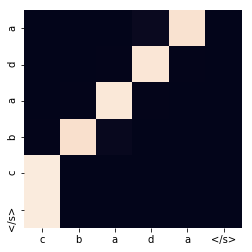

In [0]:
visualize_plot(model,'cbada')